# GEMHP (Hawkes process marked by "Topic")

We call $\bar{N}$ a $d$-dimensional generalized exponential marked Hawkes process (GEMHP) if its intensity process is

\[
	\lambda^i_t(\vartheta^*) = \mu_i(X_{t-}, \vartheta^*) + \sum_{j=1}^d \int_{[0,t) \times \mathbb{X}} \langle A_{ij}(\vartheta^*) | e^{-sB_{ij}(\vartheta^*)}\rangle g_{ij}(x, \vartheta^*) \bar{N}^j(ds, dx), \ \ i= 1, \dots, d \nonumber,
\]

where $g_{ij} : \mathbb{X} \times \Xi \to \mathbb{R}_+, A_{ij}:  \Xi \to \mathbb{R}^{p \times p}, B_{ij} : \Xi \to \mathbb{R}^{p \times p}$ are measurable functions for $ p \in \mathbb{N}$ and the real parts of the eigenvalues of $B_{ij}(\vartheta)$ are dominated by some $r > 0$ independently of $\vartheta \in \Xi$.

## Libraries

In [1]:
import math
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy import optimize, integrate
from scipy.stats import multivariate_normal, uniform, skew
import csv
from tqdm.notebook import tqdm
import itertools
import time

## Simulation

Let Generalized Elementary Excitation Process $\mathcal{E}^{ij}_t$ be

\[
    \mathcal{E}^{ij}_t = \int_{[0,t) \times \mathbb{X}} e^{-(t-s)B_{ij}} g_{ij}(x) \bar{N}^j(ds, dx)\nonumber
\]

Moreover, let $\mathcal{E}_t = \big(\mathcal{E}^{ij}_t\big)_{ij}$, $X_t$ be a mark process.
The value of the GEMHP's intensity process at time $t$ is updated based on the value of $Z_u:= (\mathcal{E}_u, X_u)$ for $t>u$ as follows:

\[
    \lambda^i_t = \mu_i + \sum_{j=1}^d \left\{ \left\langle A_{ij} \Big| e^{-(t-u)B_{ij}} \mathcal{E}^{ij}_u \right\rangle + \int_{[u,t) \times \mathbb{X}} h_{ij}(t-s, x) \bar{N}^j(ds, dx)\right\}, \ \ i = 1,\dots d. \nonumber
\]

Then, a path of the GEMHP can be simulated by using the above computation for the intensity process and Ogata's method.

In [2]:
## parameter：params = [mu, alpha, beta, m, paramsMark, initEps] (list)
### mu : d-dim Vector (np.array)
### alpha : [d, d, p]-dim Tensor (np.array)
### beta : [d, d]-dim Matrix (np.array)
### m : [d, d, d'+1]-dim Tensor (np.array)
### paramsMark: parameter for mark density
### initEps : [d, d, p, p]-dim Tensor (np.array), the initial value of elementary excitation process

## Polynomial Type Excitation Kernel w.r.t. time
def PolyExpKernel(time, params):
    ## time : : [time, ...], len(time)-dim Vector or float, int
    ## params : all parameters
    alpha = params[1]
    dim = len(params[0])
    d_alpha = len(alpha[0,0])
    #casting
    if type(time) != np.ndarray:
        time = np.array(time).reshape(1,1)
    else:
        time = np.array(time).reshape(len(time),1)
            
    fact = np.vectorize(np.math.factorial)(np.arange(d_alpha)) # [1!, 2!, 3!,...]
    components = time**np.arange(d_alpha)/fact # Ploynomial type
    expt = components[:, :d_alpha]
    for i in range(1, d_alpha):
        exptcol = np.append(np.zeros((len(time), i)), components[:, :d_alpha-i], axis=1)
        expt = np.append(expt, exptcol, axis=1)
    expt = expt.reshape(len(time), d_alpha, d_alpha)
    
    A = np.zeros((dim, dim, d_alpha, d_alpha))
    for i in range(dim):
        for j in range(dim):
            A[i,j,0] = alpha[i,j]*fact
    
    return A, expt
## Linear impact from mark
def gLinear(mark, params):
    ## mark : [x, ...], [len(mark), d']-dim matrix
    ## params_m : m_{i,j,l}, [d, d, d']-dim Tensor     
    _dim = len(params[0]) 
    #if params[3].size == 0:
    #    m = np.concatenate([np.ones((_dim, _dim, 1)), np.zeros((_dim, _dim, 1))], axis=2)
    #else:
    m = params[3]
    if mark.ndim==1: mark = mark.reshape(1, len(mark)) # casting
    #_mark = np.append(np.ones((len(mark), 1)), mark, axis=1) # Add Constant Term
    return (m@mark.T).transpose(2,0,1)

## General Excitation Kernel
def Excitor(Eps, JumpDim, mark, params, kernel = PolyExpKernel, g = gLinear):
    ## Eps : elementary excitation process, [d, d, p, p]-dim Tensor
    ## JumpDim : Dimension of the last jump
    ## mark : [x, ...], [len(mark), d']-dim matrix or d'-dim Vector
    ## params : all parameters
    ## kernel : Excitation function for time
    ## g : Excitation function for mark
    mu = params[0]
    dim = len(mu)
    d_alpha = len(params[1][0,0])
    JumpDim = int(JumpDim) # casting
    _intensity = mu.copy()
    _newEps = Eps.copy()
    _A, _exp0 = PolyExpKernel(0, params)
    _exp0 = _exp0[0]
    
    _g = g(mark, params)[0]
    
    for i in range(dim):
            _newEps[i,JumpDim-1] += _exp0*_g[i,JumpDim-1]
            for j in range(dim):
                _intensity[i] += np.sum(_A[i,j]*_newEps[i,j])

    return _intensity, _newEps
def Attenuator(delta, Eps, params, kernel = PolyExpKernel):
    ## delta : time interval
    ## Eps : elementary excitation process, [d, d, p, p]-dim Tensor
    ## prarms : params
    ## kernel : Excitation function for time
    mu = params[0]
    beta = params[2]
    dim = len(mu)
    d_alpha = len(params[1][0,0])
    
    _intensity = mu.copy()
    _newEps = np.zeros((dim, dim, d_alpha, d_alpha))
    _A, _expt = PolyExpKernel(delta, params)
    _expt = _expt[0]

    for i in range(dim):
        for j in range(dim):
            _newEps[i,j] = np.exp(-beta[i,j]*delta)*_expt@Eps[i,j]
            _intensity[i] += np.sum(_A[i,j]*_newEps[i,j])

    return _intensity, _newEps          
    
## Examples of markDist
def markMultiDirichlet(preValue, paramsMark, JumpDim, size=1, markDim=1):
    _alpha = paramsMark[0]
    return np.random.dirichlet(_alpha, size)

## Conditional Expected Size of Jump by Monte Carlo Simulation for the judge of Stability
## IID Mark Case, (Spectral radius of Phi) < 1 → Stable
def ComputeG(x, params, markDist, g = gLinear, MC = 100000, markDim=1):
    dim = len(params[0])
    _G = np.zeros((dim, dim)) 
    for j in range(dim):
        sample = markDist(x, params[4], JumpDim=j, size=MC, markDim=markDim)
        g_j = g(sample, params)
        for i in range(dim):
            _G[i,j] = np.sum(g_j[:,i,j])/MC
    return _G
def ComputeB(params):
    ## params : all parameters
    _beta = params[2]
    dim = len(params[0])
    d_alpha = len(params[1][0,0])
    _B = np.zeros((dim, dim, d_alpha, d_alpha))
    _M = np.zeros((d_alpha, d_alpha))
    
    for i in range(d_alpha):
        for j in range(d_alpha):
            if j==i+1: _M[i,j] = 1
    for i in range(dim):
        for j in range(dim):
            _B[i,j] = _beta[i,j]*np.eye(d_alpha) - _M
    return _B
def Phi(x, params, dims, markDist = markMultiDirichlet, kernel = PolyExpKernel, g = gLinear, MC = 10000):
    dim, _, _, markDim = dims
    
    _A, _ = kernel(0, params)
    _B = ComputeB(params)
    _G = ComputeG(x, params, markDist, g, MC, markDim)
    _Phi = np.zeros((dim, dim))
    for i in range(dim):
        for j in range(dim):
            _invB = np.linalg.inv(_B[i,j])
            _Phi[i,j] = np.sum(_A[i,j]*_invB)*_G[i,j]
    return _Phi
       
# Sum of the max increment of deac dimensional Kernel 
def MaxKernelUnifMark(params, dims, JumpDim, kernel=PolyExpKernel):
    _Eps = np.zeros((dims[0], dims[0], dims[1], dims[1]))
    InitIntensity, _Eps = Excitor(_Eps, JumpDim, np.array([1.]*dims[3]), params, kernel) # Unif mark <= 1
    MaxInc = 0.
    for i in range(len(params[0])):
        seq = np.arange(0, 10, 0.1)
        y = np.zeros(len(seq))
        for n in range(len(seq)):
            y[n] = Attenuator(seq[n], _Eps, params, kernel)[0][i]
        MaxInc += np.max(y)-InitIntensity[i]
    return MaxInc

############################################################################
############################################################################

## Simulate Hawkes time series with Ogata's method
def simulateGEMHP(params, t_max, dims, markDist = markMultiDirichlet, kernel = PolyExpKernel, g = gLinear):
    _params = params.copy()
    #MaxInc = MaxKernelUnifMark(_params, dims, 0, kernel) # JumpDimに依存したりMarkの上限が1でない場合は要修正
    dim, _, d_mark, markDim = dims
    if _params[3].size == 0: _params[3] = np.concatenate([np.ones((dim, dim, 1)), np.zeros((dim, dim, 1))], axis=2)
    paramsMark, initEps = _params[4], _params[5]
    arrivals = np.array([[0,1]]) # each jump times (t_{i,0} = 0 for all i)
    for i in range(1,dim):
        arrivals = np.append(arrivals, np.array([[0,i+1]]), axis=0)
    x = np.zeros(d_mark)
    marks = np.zeros((1,d_mark+1)) # each marks
    delta = 0 # last jump time interarrival
    t = 0 # last jump time

    ### Case: first jump
    # Calculate now intensity at t = 0
    # and consider the 1-dim P.P. with intensity lambda_bar
    intensity, Eps = Attenuator(0, initEps, _params)
    lambda_bar = np.sum(intensity)#+MaxInc 
    delta = -np.log(np.random.uniform())/lambda_bar
    t = delta
    if t>t_max:
        for i in range(dim):
            arrivals = np.append(arrivals, np.array([[t_max,i+1]]), axis=0)
        return arrivals, marks[1:]

    # Calculate now intensity at t = delta- (※ not jump yet!)
    intensity, Eps = Attenuator(delta, Eps, _params, kernel)

    ## Searching for which dimension a jump is occuring in
    D = np.random.uniform()
    cum_lambda = np.sum(intensity)
    if D*lambda_bar<cum_lambda:
        # Searching for the first k such that D*lambda <= cum_lambda_k
        k = 1 # JumpDim
        cum_lambda_k = np.sum(intensity[:k])
        while D*lambda_bar>cum_lambda_k:
            k += 1
            cum_lambda_k = np.sum(intensity[:k])
        arrivals = np.append(arrivals, np.array([[t,k]]), axis=0)
        x = markDist(x, paramsMark, k, markDim=markDim)
        marks = np.append(marks, [np.append(x[0],k)], axis=0)
    else:# there are no jumps
        k = 0

    ### Case: other jumps
    while t < t_max:
        # Calculate now intensity at t = t+
        # and consider the 1-dim P.P. with intensity lambda_bar
        if k!=0: 
            intensity, Eps = Excitor(Eps, k, x, _params, kernel, g)
        lambda_bar = np.sum(intensity)#+MaxInc
        delta = -np.log(np.random.uniform())/lambda_bar
        t = t + delta
        if t > t_max:
            for i in range(dim):
                arrivals = np.append(arrivals, np.array([[t_max,i+1]]), axis=0)
            return arrivals, marks[1:]

        # calculate now intensity at t = t + s-
        intensity, Eps = Attenuator(delta, Eps, _params, kernel)

        ## Searching for which dimension a jump is occuring in
        D = np.random.uniform()
        cum_lambda = np.sum(intensity)
        if D*lambda_bar<cum_lambda:
            # Searching for the first k such that D*lambda <= cum_lambda_k
            k = 1
            cum_lambda_k = np.sum(intensity[:k])
            while D*lambda_bar>cum_lambda_k:
                k += 1
                cum_lambda_k = np.sum(intensity[:k])
            arrivals = np.append(arrivals, np.array([[t,k]]), axis=0)
            x = markDist(x, paramsMark, k, markDim=markDim)
            marks = np.append(marks, [np.append(x[0],k)], axis=0)
        else:# there are no jumps
            k = 0

## QMLE

The quasi log-likelihood function as the objective functions for the GEMHP:

\[
    l_T(\vartheta) = \sum_{i=1}^d \left\{ \int_0^T \log \lambda^i(t, \vartheta)N^i(dt) - \int_o^T \lambda^i(t, \vartheta)dt + \int_{[0,T] \times \mathbb{X}} \log q^i(s, x, \vartheta) \bar{N}^i(ds, dx) \right\} 
    =: \sum_{i=1}^d \left\{ \mathbb{A}^i_T(\vartheta) + \mathbb{B}^i_T(\vartheta) + \mathbb{C}^i_T(\vartheta) \right\} \nonumber
\]

Let $\tau^i_n$ be the $n$-th jump of $N^i$. 
Moreover, we can write

\[
    \mathbb{A}^i_T(\vartheta)
    = \sum_{n=1}^{N^i_T} \log \left( \mu_i + \sum_{j=1}^d \sum_{\tau^j_m < \tau^i_n} \left\langle A_{ij} \Big| e^{-(\tau^i_n - \tau^j_m)B_{ij}} \right\rangle g_{ij}\big(X_{\tau^j_m}, \vartheta\big) \right), \nonumber
\]

\[
    \mathbb{B}^i_T(\vartheta) = -\mu_i T + \sum_{j=1}^d \sum_{n=1}^{N^j_T} \sum_{m=1}^{n-1} \left\langle A_{ij} \Big| B^{-1}_{ij} \big( e^{-(\tau^j_n - \tau^j_m)B_{ij}} - e^{-(\tau^j_{n-1} - \tau^j_m)B_{ij}} \big) \right\rangle g_{ij}\big(X_{\tau^j_m}, \vartheta\big), \nonumber
\]


\[
    \mathbb{C}^i_T(\vartheta) = \sum_{n=1}^{N^i_T} \log p\big(X_{\tau^i_n}, \theta\big). \nonumber
\]

Then, we can define the quasi maximum likelihood estimator (QMLE) $\tilde{\vartheta}_T$ as a quantity satisfying

\[
	\tilde{\vartheta}_T = \big( \tilde{\theta}^0_T, \tilde{\theta}^1_T, \tilde{\nu}^0_T, \tilde{\nu}^1_T \big)  \in argmax_{\vartheta \in \Xi} l_T(\vartheta). \nonumber
\]

※ Here, we consider the situation that the mark parameter is known. Thus, we can assume that $\mathbb{C}^i_T(\vartheta) = 0$.

In [8]:
## Compute \exp^{tB}
def exptB(i, j, dtime, params):
    beta = params[2]
    _, _expt = PolyExpKernel(dtime, params)
    _expB = np.exp(-beta[i,j]*dtime)
    _exptB = _expt*_expB.reshape(len(_expB), 1, 1)
    return _exptB
## Params Cast w.r.t. Hawkes
def ParamsToVector(params, paramsMarkToVector = markMultiNormalToVector): # Drop alpha
    ## Initial Eps is ignored
    mu = params[0]
    beta = params[2].reshape(1, -1)[0]
    m = params[3].reshape(1, -1)[0]
    if len(params)==5: 
        paramsMark = paramsMarkToVector(params[4])
        return np.concatenate([mu, beta, m, paramsMark])
    else:
        return np.concatenate([mu, beta, m])  
def ParamsToList(paramsVector, dims, TrueParamsMark = None, paramsMarkToList = markMultiNormalToList, initEps = None): # Attach alpha
    dim, d_alpha, d_mark, MarkDim = dims
    preID, ID = 0, dim
    if paramsVector[preID:ID].size == 0:
        mu = np.array([])
    else:
        mu = paramsVector[preID:ID]
    preID, ID = ID, ID + dim*dim
    if paramsVector[preID:ID].size == 0:
        beta = np.array([])
    else:
        beta = paramsVector[preID:ID].reshape(dim, dim)
    preID, ID = ID, ID + dim*dim*(d_mark)
    if paramsVector[preID:ID].size == 0:
        m = np.array([])
    else:
        m = paramsVector[preID:ID].reshape(dim, dim, d_mark)
    alpha = np.array([1]*(dim**2)).reshape(dim, dim, d_alpha)
    if TrueParamsMark == None:
        paramsMarkToList(paramsVector[ID:], MarkDim)
    else:
        paramsMark = TrueParamsMark
    if initEps == None:
        initEps = np.zeros((dim, dim, d_alpha, d_alpha)) # if initEps = None, it is 0
    return [mu, alpha, beta, m, paramsMark, initEps]

## Only for i.i.d. mark
## Order : O(dim*dim*N_T)
## C = 0
def LogLikelihood(paramsVector, args, kernel = PolyExpKernel, g = gLinear):
    arrivals, marks, dims, TrueParamsMark = args
    _mu, _alpha, _beta, _m, _paramsMark, _initEps = ParamsToList(paramsVector, dims, TrueParamsMark=TrueParamsMark)
    _params = [_mu, _alpha, _beta, _m, _paramsMark, _initEps]
    #if max(abs(LA.eig(Phi(0, _params, dims))[0]))>1 or max(abs(LA.eig(Phi(0, _params, dims))[0]))<1e-5: # Check the Stability
    #    print(max(abs(LA.eig(Phi(0, _params, dims))[0])))
    #    return 10e+10
    dim, d_alpha, d_mark, MarkDim = dims
    t_max = arrivals[-1][0]
    _A, _ = PolyExpKernel(0, _params)
    _invB = np.linalg.inv(ComputeB(_params))
    
    time = [] # arrival times for each dim : [[\tau^1_1,...], [\tau^2_1,...], ...]
    mark = [] # marks for each dim : [[X_{\tau^1_1}, ... ], [X_{\tau^2_1}, ... ], ...]
    gValues = [] # [g(X_{\tau_1}), g(X_{\tau_2}), ...]
    for i in range(dim):
        time.append((arrivals[arrivals.T[:][1] == i+1]).T[:][0][1:])
        mark.append(marks[marks.T[:][-1] == i+1][:,:-1])
        gValues.append(g(mark[-1], _params))
    # log-likelihood
    bbA, bbB = np.zeros(dim), -_mu*t_max
    for i in range(dim):
        for j in range(dim):
            for n in range(1,len(time[j])):
                # Bの計算
                dtime1 = time[j][n]-time[j][time[j][:]<time[j][n]]
                dtime2 = np.append(time[j][n-1]-time[j][time[j][:]<time[j][n-1]],0)
                exptB1 = exptB(i, j, dtime1, _params)
                exptB2 = exptB(i, j, dtime2, _params)
                bbB[i] += np.sum(np.sum((_A[i,j]*(_invB[i,j]@(exptB1-exptB2))).reshape(len(dtime1),d_alpha**2), axis=1)*gValues[j][:n,i,j])
    for i in range(dim):
        for n in range(len(time[i]))[:-1]:
            expbbAi = _mu[i]
            # Aの計算
            for j in range(dim):
                dtime3 = time[i][n]-time[j][time[j][:]<time[i][n]]
                exptB3 = exptB(i, j, dtime3, _params)
                expbbAi += np.sum(np.sum((_A[i,j]*exptB3).reshape(len(dtime3),d_alpha**2), axis=1)*gValues[j][:np.sum(time[j][:]<time[i][n]),i,j])
            bbA[i] += np.log(expbbAi)
            #print("bbA", bbA[i])
    #print(paramsVector)
    return (-1)*(np.sum(bbA+bbB))

# P-O Estimator

In the P-O method, the estimation is done in three steps.


Step 1 : We obtain the first estimator of $\vartheta$ by

\[
    \big( \tilde{\theta}^0_T, \tilde{\theta}^1_T, \tilde{\nu}^0_T, \tilde{\nu}^1_T \big) = argmin_{\vartheta \in \Xi} l_T(\vartheta).\nonumber
\]
        
Step 2 : We obtain the second estimator of $(\theta^0, \nu^0)$ by

\[
	\big( \hat{\theta}^{0,(q)}_T, \hat{\nu}^{0,(q)}_T \big) = argmin_{ (\theta^0, \nu^0 ) \in \bar{\Theta}^0 \times \bar{\mathcal{N}}^0} Q^{(q)}_T(\theta^0, \nu^0).\nonumber
\]
        
Step 3 : We obtain the third estimator of $\vartheta$ by

\[
    \big( \check{\theta}^0_T, \check{\theta}^1_T, \check{\nu}^0_T, \check{\nu}^1_T \big) = argmin_{ \vartheta \in \hat{\Theta}^0_T \times \Theta^1 \times \hat{\mathcal{N}}^0_T \times \mathcal{N}^1} l_T(\vartheta),\nonumber
\]
        
where $\hat{\Theta}^0_T = \big\{\theta^0 \in \bar{\Theta}^0 \big| \theta^0_j = 0, j \in \hat{\mathcal{J}}^0_T \big\}, \hat{\mathcal{J}}^0_T = \big\{ j = 1, \dots, p_0 \big| \hat{\theta}^{0, (q)}_j = 0 \big\}, \hat{\mathcal{N}}^0_T = \big\{\nu^0 \in \bar{\mathcal{N}}^0 \big| \nu^0_j = 0, j \in \hat{\mathcal{K}}^0_T \big\}$ and $\hat{\mathcal{K}}^0_T = \big\{ j = 1, \dots, n_0 \big| \hat{\nu}^{0, (q)}_j = 0 \big\}$.
The objective function $Q^{(q)}_T(\theta^0, \nu^0)$ is constructed by using the first estimators $\tilde{\theta}^0_T, \tilde{\nu}^0_T$ as below.

\[
	Q^{(q)}_T(\theta^0, \nu^0) = \sum_{j=1}^{p_0} \Big( \big( \theta^0_j - \tilde{\theta}^0_j \big)^2 + \kappa^{\theta}_j | \theta_j |^q \Big) +  \sum_{j=1}^{n_0} \Big( \big( \nu^0_j - \tilde{\nu}^0_j \big)^2 +\kappa^{\nu}_j  | \nu_j |^q \Big) \nonumber
\]

where $q \in (0, 1],  \kappa^{\theta}_j = \frac{T^{-\frac{1+a}{2}}}{\big| \tilde{\theta}_j + T^{-\frac{1}{2}} \big|^{\gamma}},  \kappa^{\nu}_j = \frac{T^{-\frac{1+a}{2}}}{\big| \tilde{\nu}_j + T^{-\frac{1}{2}} \big|^{\gamma}}, \gamma > -(1-q)$ and $a \in (1-q-\gamma, 0)$.

In [9]:
# Step. 1. : Estimate MLE by LogLikelihood
# Step. 2.a. : Extract possibly zero components from MLE by LSAParams
# Step. 2.b. : Estimate LSAE by LSA
# Step 3.a. : Extract zero components from LSAE by LSAParams
# Step 3.b : Estimate P-O by ElimLogLikelihood

# Extract possibly zero components (mu, m) for ElimZeroParams
def LSAParams(paramsVector, dims, bounds):
    dim, d_alpha, d_mark, markDim = dims
    LSAParamsVector = np.concatenate([paramsVector[:dim], paramsVector[-(d_mark*dim**2)-1:]])
    low_bd = np.concatenate([bounds[0][:dim], bounds[0][-(d_mark*dim**2)-1:]])
    up_bd = np.concatenate([bounds[1][:dim], bounds[1][-(d_mark*dim**2)-1:]])
    LSABounds = [low_bd, up_bd]
    return LSAParamsVector, LSABounds
# Reconstruct full parameter from LSAParamsVector.
def ReconstLSAParams(LSAParamsVector, paramsVector, dims):
    dim, d_alpha, d_mark, markDim = dims
    ParamsVector = np.concatenate([LSAParamsVector[:dim], paramsVector[dim:-(d_mark*dim**2)-1], LSAParamsVector[-(d_mark*dim**2)-1:]])
    return ParamsVector
# Eliminate zero components
def ElimZeroParams(paramsVector, bounds):
    nonZeroId = paramsVector!=0
    elimParamsVector = paramsVector[nonZeroId]
    low_bd = bounds[0][nonZeroId].tolist()
    up_bd = bounds[1][nonZeroId]
    elimBounds = [low_bd, up_bd]
    return elimParamsVector, nonZeroId, elimBounds
# Reconstruct full parameter from elimParamsVector.
def ReconstZeroParams(elimParamsVector, nonZeroId):
    paramsVector = np.array(nonZeroId, float) # Zero params are zero
    paramsVector[nonZeroId] = elimParamsVector
    return paramsVector

# Objective function (Least Square Approximation)
def LSA(zeroParamsVector, args): 
    zeroPreEstVector, dims, t_max, gamma, a, q = args # where zeroPreEstVector = LSAParams(preEstVector, dims)
    kappa = t_max**(-(1+a)/2)*(zeroPreEstVector+1.0e-5*t_max**(-1/2))**(-gamma) # 罰則項係数．
    lsa = np.sum((zeroParamsVector-zeroPreEstVector)**2 + kappa*zeroParamsVector**q)
    return lsa
# Objective function (LogLikelihood)
def ElimLogLikelihood(elimParamsVector, args, kernel = PolyExpKernel, g = gLinear):
    arrivals, marks, dims, paramsMark, nonZeroId = args
    paramsVector = ReconstZeroParams(elimParamsVector, nonZeroId)
    return LogLikelihood(paramsVector, [arrivals, marks, dims, paramsMark], kernel, g)

# Step1: LSE -> Step2: LSA -> Step3: QMLE
# bounds1, bounds2はlistで渡し，full paramsに対して定義しておく．Step2ではbounds1を，Step3ではbounds2を間引いて使用する．
def PO(args, x0, bounds, method='L-BFGS-B', gamma=2., a=0.5, q=1., text=True):
    arrivals, marks, dims, paramsMark = args
    Bounds = optimize.Bounds(bounds[0], bounds[1])
    #initValue = x0 + np.random.uniform(size=len(x0))*1.0e-3 # noize for initial value
    mle = optimize.minimize(fun=LogLikelihood, x0=x0, args=args, method='L-BFGS-B', bounds=Bounds)
    
    LSAMLEVector, LSABounds = LSAParams(mle.x, dims, bounds)
    LSABounds = optimize.Bounds(LSABounds[0], LSABounds[1])
    argsLSA = [LSAMLEVector, dims, arrivals[-1][0], gamma, a, q]
    lsae = optimize.minimize(fun=LSA, x0=LSAMLEVector, args=argsLSA, method='L-BFGS-B', bounds=LSABounds)
    
    LSAVector = ReconstLSAParams(lsae.x, mle.x, dims)
    elimLSAVector, nonZeroId, elimBounds = ElimZeroParams(LSAVector, bounds)
    elimBounds = optimize.Bounds(elimBounds[0], elimBounds[1])
    argsElimMLE = [arrivals, marks, dims, paramsMark, nonZeroId]
    elimpoe = optimize.minimize(fun=ElimLogLikelihood, x0=elimLSAVector, args=argsElimMLE, method='L-BFGS-B', bounds=elimBounds)
    
    if text:
        print(mle, '\n\n', lsae, '\n\n', elimpoe)   
    
    poe = ReconstZeroParams(elimpoe.x, nonZeroId)

    return poe, mle.x

## Hawkes process marked by "Topic"

Let $\bar{N}$ be the GEMHP whose intensity is

\[
	\lambda^i_t(\vartheta^*) = \mu_i + \sum_{j=1}^d \int_{[0,t) \times \mathbb{X}} e^{-(t-s)\beta_{ij}}\Bigg( \sum_{l=1}^{d'} m_{ijl}x_{l} \Bigg) \bar{N}^j(ds, dx) \bigg|_{\vartheta = \vartheta^*}, \quad i = 1,\dots d,\nonumber
\]

and the mark is distributed on the $(d'-1)$-simplex, i.e. the set $\big\{ x= (x^1, \dots, x^{d'}) \in \mathbb{R}_+^{d'} \big| \sum_{i=1}^{d'}x^i = 1 \big\}$, and has the transition kernel

\[
	Q_j(x ,dy, \theta_M) = p_j(x ,y, \theta_M) dy,\nonumber
\]

where $\vartheta = \big( \{m_{ijl}\}_{ijl}, \{\mu_i\}_i, \{\beta_{ij}\}_{ij}, \theta_M \big) \in \Xi \subset \mathbb{R}_+^{d^2 \times d'} \times \mathbb{R}_{>0}^{d+d^2} \times \mathbb{R}^{d''}$ is a parameter and $\vartheta^*= \big(\{m^*_{ijl}\}_{ijl}, \{\mu^*_i\}_i, \{\beta^*_{ij}\}_{ij} , \theta_M^*\big) \in \Xi$ is the true value.

### Example : 1-dim GEMHP with 3-dim Dirichlet distribution mark

Let the GEMHP $\bar{N}$ whose intensity is

\[
 	\lambda_t(\vartheta^*) = \mu^* + \int_{[0,t) \times \mathbb{X}} e^{-\beta^*(t-s)} \big(m^*_1x_1 + m^*_2x_2 + m^*_3x_3 \big)\bar{N}(ds, dx),\nonumber
\]

where 

\[
    \mu^* = 1.5, \ \
    \beta^* = 0.5, \ \
    (m^*_1, m^*_2, m^*_3) = (0.4, 0.0, 0.4)\nonumber
\]

and marks independently and identically follow the $3$-dimensional Dirichlet distribution with a parameter $\alpha = (2, 2, 5)$.

In [10]:
## e.g.1 Setting
np.random.seed(0)

dims = [1, 1, 3, 3] # dim, d_alpha, d_mark (= d, p, d') , dim of mark
mu = np.array([1.5], dtype=float)
alpha = np.array([[[1]]], dtype=float)
beta = np.array([[0.5]], dtype=float)
m = np.array([[[0.4,0,0.4]]], dtype=float)
paramsMark = [np.array([2,2,5], dtype=float)] # Dirichlet Param
initEps = np.zeros((dims[0], dims[0], dims[1], dims[1]))
params = [mu, alpha, beta, m, paramsMark, initEps]
paramsVector = ParamsToVector(params)

t_max = 2000 # Observed Time
low_bd, up_bd = np.repeat(0., len(paramsVector)), np.repeat(1.e+10, len(paramsVector))
low_bd[:-(dims[2]*dims[0]**2)] += 0.0001
bounds = [low_bd, up_bd] # Bounds for parameter

## Monte Calro Simulation
MC = 300 # Number of Monte Calro
mleList = []
poeList = []
mleErrorList = []
poeErrorList = []
cnt = 0
pbar = tqdm(total=MC)
while cnt < MC:
    arrivals, marks = simulateGEMHP(params, t_max, dims)
    args = [arrivals, marks, dims, paramsMark]
    poe, mle = PO(args, paramsVector, bounds, text=False)
    print(len(arrivals), mle, poe)
    mleList.append(mle)
    poeList.append(poe)
    mleErrorList.append(np.sqrt(t_max)*(mle - paramsVector))
    poeErrorList.append(np.sqrt(t_max)*(poe - paramsVector))
    pbar.update(1)
    cnt += 1

  0%|          | 0/300 [00:00<?, ?it/s]

7706 [1.36872052 0.509345   0.6085555  0.         0.34775034] [1.36920999 0.50965067 0.60910637 0.         0.34778621]
8165 [1.7239925  0.58210678 0.87486481 0.         0.25611919] [1.72392091 0.58205644 0.87461497 0.         0.2561836 ]
7834 [1.35522019 0.43360669 0.3107823  0.15324066 0.32600413] [1.35489547 0.43361816 0.31079598 0.15292951 0.32619644]
7581 [1.71965039 0.45589346 0.23938031 0.07712935 0.32140742] [1.72848398 0.45271282 0.25359607 0.         0.3412906 ]
7921 [1.61045129 0.50761582 0.39048446 0.04469938 0.36879418] [1.61236445 0.50595322 0.40371384 0.         0.37915368]
8257 [1.41126127 0.47066169 0.37976179 0.         0.40502073] [1.41192067 0.47062813 0.3776228  0.         0.40570491]
7909 [1.34532338 0.46512842 0.47832307 0.         0.35972762] [1.34537635 0.46505574 0.47633524 0.         0.36043329]
7756 [1.50855067 0.44680199 0.30466821 0.         0.37075384] [1.50784669 0.44667129 0.30455319 0.         0.37079711]
8001 [1.28656177 0.43983692 0.32343869 0.       

7571 [1.28372705 0.48631012 0.3559587  0.08704095 0.40313375] [1.29608233 0.48632207 0.37853302 0.         0.4265737 ]
7817 [1.60195915 0.45246161 0.59579273 0.10148718 0.20381037] [1.62294605 0.45478412 0.62128385 0.         0.23226906]
7862 [1.49113062 0.51784584 0.38299285 0.         0.42438393] [1.49147359 0.51790318 0.38284691 0.         0.4244248 ]
8124 [1.61631544 0.47974358 0.45904208 0.08501092 0.3030886 ] [1.61941451 0.4750434  0.47937321 0.         0.32343227]
7698 [1.2892139  0.51524065 0.32507568 0.28658801 0.37273537] [1.28868527 0.51509596 0.32602656 0.28561007 0.37268946]
7941 [1.59745112 0.62020202 0.43641403 0.         0.49193647] [1.59738589 0.62015857 0.43632586 0.         0.49194417]
8664 [1.41973654 0.46815602 0.24505827 0.         0.47105349] [1.42023207 0.46824615 0.24495796 0.         0.47110713]
7829 [1.4334956  0.51349611 0.54386445 0.0660498  0.34203108] [1.43941538 0.51206674 0.56409367 0.         0.35720191]
8112 [1.45078594 0.50893159 0.97428377 0.0109173

7668 [1.66529114 0.54420413 0.3735805  0.04140114 0.38804084] [1.67034771 0.54407766 0.38610016 0.         0.39811289]
7731 [1.495091   0.44830061 0.25163944 0.         0.39491078] [1.49643858 0.44852652 0.25149702 0.         0.39494046]
8296 [1.48098972 0.40201908 0.29255298 0.02879411 0.338187  ] [1.48386952 0.40149764 0.29948049 0.         0.34589827]
7634 [1.60454585 0.57780742 0.55256184 0.         0.38303075] [1.60429823 0.57769755 0.55218881 0.         0.3831341 ]
7762 [1.79466174 0.57589142 0.35895358 0.         0.41657211] [1.79472685 0.57586963 0.35899019 0.         0.41651875]
7810 [1.57602561 0.53503597 0.3022918  0.         0.45653856] [1.57587896 0.53497484 0.30223037 0.         0.45653344]
8015 [1.67480731 0.55994945 0.4284494  0.         0.41582991] [1.67485156 0.55990169 0.42775476 0.         0.41604919]
8107 [1.5774037  0.5007865  0.23384776 0.         0.45627717] [1.57961521 0.50122482 0.2335198  0.         0.45641734]
8224 [1.7629721  0.57211556 0.52489776 0.1025214

7664 [1.30604139 0.54211461 0.4862042  0.4436388  0.27173095] [1.30807369 0.54263135 0.48755985 0.44359323 0.27132548]
7955 [1.74955702 0.53308862 0.58615915 0.06573224 0.27570554] [1.75612985 0.53290513 0.60504003 0.         0.29242169]
7963 [1.47851953 0.54452222 0.24808798 0.         0.51499437] [1.47902514 0.54454999 0.24806499 0.         0.5149006 ]
7707 [1.59084999 0.61196508 0.12482101 0.14811224 0.53765234] [1.5904652  0.61192116 0.12378695 0.14911292 0.53774335]
7626 [1.4209787  0.55672944 0.39646494 0.08884236 0.43351548] [1.42618997 0.55509472 0.42080828 0.         0.45565291]
7322 [1.44193418 0.42887567 0.40657551 0.01040825 0.30011045] [1.44326771 0.42885582 0.40583317 0.         0.30421061]
8686 [1.75520456 0.47805258 0.27190103 0.         0.40611561] [1.75536786 0.478061   0.27193753 0.         0.40608203]
8267 [1.71842742 0.62033731 0.52682218 0.         0.44115475] [1.71840867 0.6203357  0.52680777 0.         0.44115804]
7975 [1.63169503 0.45072143 0.5321023  0.0269391

7962 [1.55402534 0.53456922 0.35677726 0.03166003 0.43030804] [1.55746792 0.53448295 0.36504497 0.         0.4386484 ]
8220 [1.56527136 0.56874452 0.38944952 0.         0.47597467] [1.56514781 0.56870554 0.3894142  0.         0.47597575]
8088 [1.4447103  0.4371042  0.33251883 0.17949406 0.30137314] [1.44460913 0.43709065 0.33236805 0.17953706 0.30141968]
7534 [1.38462856 0.47958063 0.31371754 0.18642648 0.34741027] [1.38422315 0.47943888 0.31360174 0.1860184  0.34757964]
8178 [1.41911803 0.52481489 0.40534221 0.01339539 0.45010624] [1.41952694 0.52403956 0.4083668  0.         0.45327195]
7983 [1.52128584 0.50839286 0.22703015 0.06857466 0.44841986] [1.52755634 0.50681642 0.24149564 0.         0.4667896 ]
7528 [1.41540091 0.4446264  0.50416881 0.         0.29622381] [1.41629965 0.44483367 0.5047029  0.         0.29606341]
7958 [1.47569731 0.52509101 0.43799365 0.11887038 0.37206421] [1.47675576 0.52520563 0.4379244  0.11843328 0.3721523 ]
7752 [1.58593527 0.56099478 0.6359816  0.       

In [11]:
def NumOfZero(poeList):
    for i in range(len(poeList[0])):
        print(i, ":", np.sum(np.array(poeList)[:,i]==0), "(", np.round(np.sum(np.array(poeList)[:,i]==0)/3, 3), "%)")

In [12]:
NumOfZero(poeList)

0 : 0 ( 0.0 %)
1 : 0 ( 0.0 %)
2 : 11 ( 3.667 %)
3 : 254 ( 84.667 %)
4 : 0 ( 0.0 %)


In [13]:
NumOfZero(mleList)

0 : 0 ( 0.0 %)
1 : 0 ( 0.0 %)
2 : 0 ( 0.0 %)
3 : 150 ( 50.0 %)
4 : 0 ( 0.0 %)


In [14]:
def Gradient(f, x, args, delta=1.0e-10):
    _grad = np.zeros(len(x))
    for i in range(len(x)):
        xh = x.copy()
        xh[i] += delta
        _grad[i] = (f(xh, args) - f(x, args))/delta
    return _grad
def GEMHP_Hist(data, dims, title="Histgram", SavePath=""):
    FigColNum = 1+dims[0]+dims[0]*dims[2]
    fig = plt.figure(figsize=(20,20/FigColNum))
    plt.subplots_adjust(top=0.8, bottom = 0.2, hspace=0.3, wspace=0.2)
    gs = gridspec.GridSpec(dims[0], FigColNum)

    for i in range(dims[0]):
        ax = fig.add_subplot(gs[i,0])
        plt.subplot(gs[i,0])
        MuData = np.array(data).T[i]
        ax.hist(MuData, bins=25, color="green")
        plt.xlabel(r'$ \mu_{%d} $' %(i+1), fontsize=20)
        ax.grid()     
    for i in range(dims[0]):
        for j in range(dims[0]):            
            ax = fig.add_subplot(gs[i,1+j])
            plt.subplot(gs[i,1+j])
            BetaData = np.array(data).T[dims[0]+dims[0]*i+j]
            ax.hist(BetaData[BetaData<50], bins=25, color="blue")
            plt.xlabel(r'$ \beta_{%d%d} $' %((i+1), (j+1)), fontsize=20)
            ax.grid()      
    for i in range(dims[0]):
        for j in range(dims[0]):
            for k in range(dims[2]):
                ax = fig.add_subplot(gs[i,1+dims[0]+dims[2]*j+k])
                plt.subplot(gs[i,1+dims[0]+dims[2]*j+k])
                MData = np.array(data).T[dims[0]++dims[0]**2+dims[0]*dims[2]*i+dims[2]*j+k]
                ax.hist(MData[MData<50], bins=25, color="purple")
                plt.xlabel(r'$ m_{%d%d%d} $' %((i+1), (j+1), (k+1)), fontsize=20)
                ax.grid()  
        
    fig.suptitle(title, fontsize=25)
    plt.show()
    if SavePath != "" : fig.savefig(SavePath)
    return None

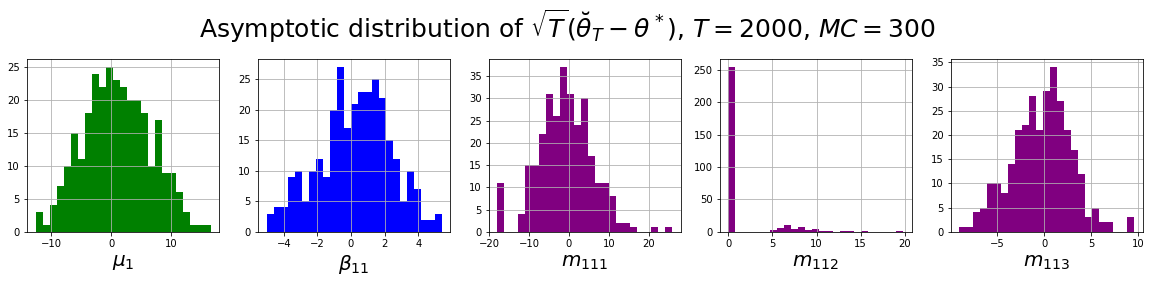

In [15]:
title = r'Asymptotic distribution of $\sqrt{T}(\breve{\theta}_T - \theta^*)$, $T=%d$, $MC=%d$' %(t_max, MC)
SavePath = 'POE/POE_eg2_AN_T=%d_MC=%d.eps'  %(t_max, MC)
GEMHP_Hist(poeErrorList, dims, title, SavePath)

In [9]:
##　Generate Path of Intensity
def Intensity(arrivals, marks, delta, params, kernel = PolyExpKernel, g = gLinear):
    # Output : Res = np.array([[value of intensity, time, dim], ...])
    _params = params.copy()
    dim = len(_params[0])
    if _params[3].size == 0: _params[3] = np.concatenate([np.ones((dim, dim, 1)), np.zeros((dim, dim, 1))], axis=2)
    mu, alpha, beta, m, paramsMark, initEps = _params
    d_alpha, d_mark = len(alpha[0,0]), len(m[0,0])-1
    
    ## Initial Value
    intensity, Eps = Attenuator(0, initEps, _params, kernel)
    Res = np.concatenate([[intensity], [np.zeros(dim)], [range(1,dim+1)]]).T

    ## Values of Intensity
    for i in range(dim-1, len(arrivals)-(dim-1)-1): # 最初と最後は打点がdim個だけ被っているため，取り除いて考える
        t_seq = np.arange(arrivals[i][0], arrivals[i+1][0], delta) # intervalを間隔deltaで刻む
        for t in t_seq:
            intensity, Eps = Attenuator(delta, Eps, _params, kernel)
            Res = np.append(Res, np.array([intensity, np.repeat(t, dim), range(1,dim+1)]).T, axis=0)
        # seqで間引かれるため，最後の点は別途計算
        intensity, Eps = Attenuator(arrivals[i+1][0] - t_seq[-1], Eps, _params, kernel)
        Res = np.append(Res, np.array([intensity, np.repeat(arrivals[i+1][0], dim), range(1,dim+1)]).T, axis=0)
        # Jumpさせる
        if i < len(arrivals)-(dim-1)-2: # Marksのサイズはarrivalと異なることに注意
            intensity, Eps = Excitor(Eps, marks[i+1-dim, -1], marks[i+1-dim, :-1], _params, kernel, g)

    return Res
## Function for Plot
def GEMHP_Plot(arrivals, marks, delta, params, kernel = PolyExpKernel, g = gLinear, SavePath="", MarkPlot= True):
    # Simulation p.p.
    t_max = arrivals[-1][0]
    # Simulation intensity
    _Intensity = Intensity(arrivals, marks, delta, params, kernel, g)
    
    # plot用の画面分割
    dim = len(params[0])
    markDim = len(marks[0])-1
    if MarkPlot:
        fig = plt.figure(figsize=(15, 4*(2+markDim)/dim))
        gs = gridspec.GridSpec(4+markDim,dim)
    else:
        fig = plt.figure(figsize=(15, 8/dim))
        gs = gridspec.GridSpec(4,dim)
        
    plt.subplots_adjust(hspace=0,wspace=0.3)

    for i in range(dim):
        time = arrivals[arrivals.T[:][1]==i+1]
        time = time.T[:][0]
        N = np.append(np.array(range(len(time)-1)), len(time)-2)     
        ax = fig.add_subplot(gs[0:2,i])
        ax.set_xlim([-t_max*0.03, t_max*1.03])
        ax.plot(time, N,  color='red', drawstyle='steps-post')
        ax.set_ylabel("$N^{%d}$" %(i+1), fontsize=20)
        ax.grid()

        lambda_i = _Intensity[_Intensity.T[:][2]==i+1]
        time = lambda_i.T[:][1]
        lambda_i = lambda_i.T[:][0]
        ax = fig.add_subplot(gs[2:4,i])
        ax.set_xlim([-t_max*0.03, t_max*1.03])
        ax.set_ylim([0, max(lambda_i)*1.1])
        ax.plot(time, lambda_i,  color='blue')
        ax.axhline(params[0][i], ls = "-.", color = "magenta")
        ax.set_ylabel("$\lambda^{%d}$" %(i+1), fontsize=20)
        ax.grid()
        
        if MarkPlot:
            for j in range(markDim):
                time = arrivals.T[:][0][dim:-dim]
                ax = fig.add_subplot(gs[4+j,i])
                ax.set_xlim([-t_max*0.03, t_max*1.03])
                ax.set_ylim([0, 1.1])
                ax.bar(time, marks[:,j], width=t_max*0.002, color="green")
                ax.set_ylabel("Topic $%d$" %(j+1), fontsize=20)
                ax.grid()
            
        ax.set_xlabel("time", fontsize=20)

    fig.suptitle('GEMHP Simulation', fontsize=30)
    plt.show()
    if SavePath != "" : fig.savefig(SavePath)

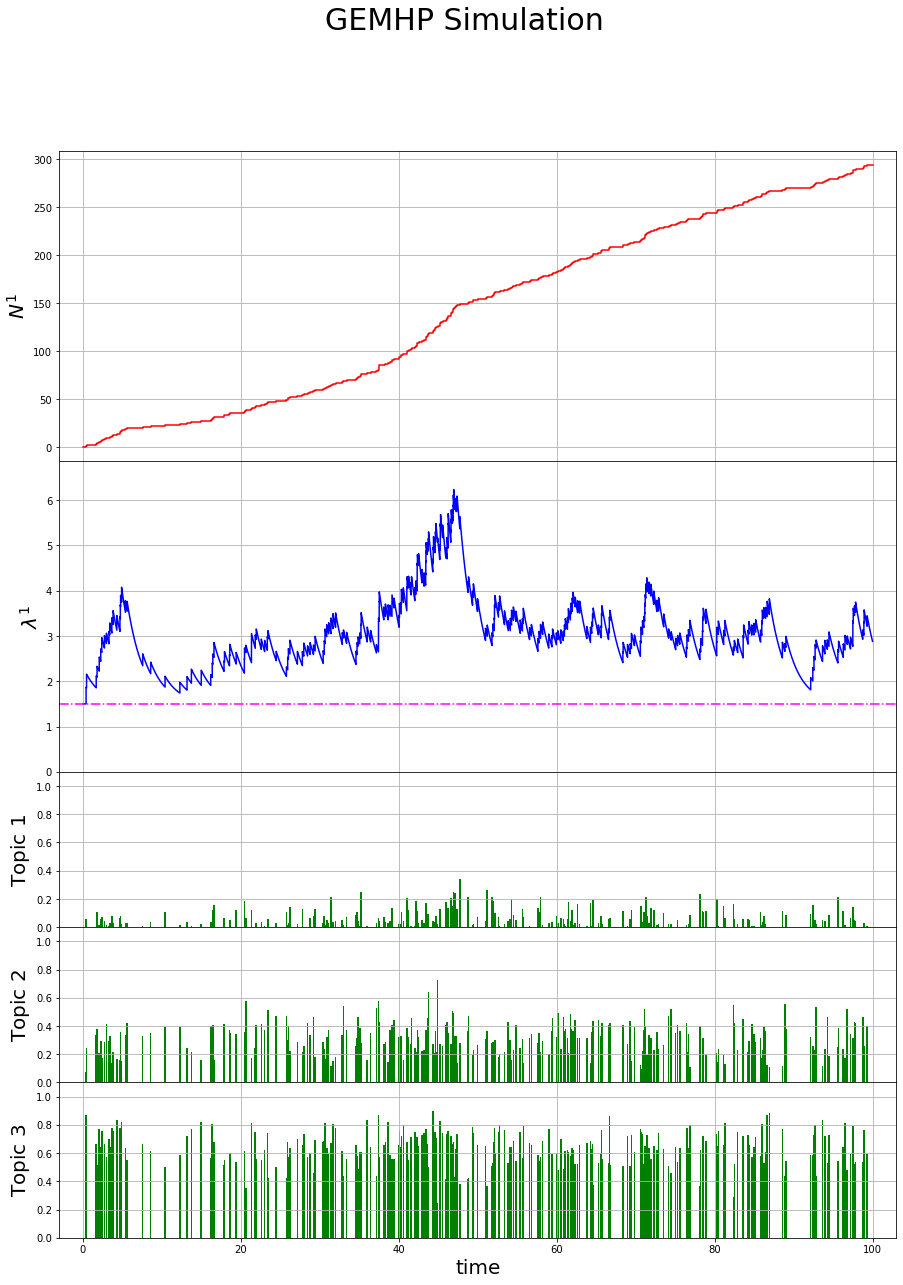

In [10]:
GEMHP_Plot(arrivals, marks, 0.01, params)